<a href="https://colab.research.google.com/github/Rawiah0/Transfer_learning_VS_Regular_CNN/blob/main/Train_ResNet50_and_Regular_CNN_on_Chest_X_Ray_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # The [dataset](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data) used is from Kaggle

# Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import keras
from keras import layers, models, applications
from sklearn.metrics import f1_score
import time
import os
from keras.models import load_model
from sklearn.metrics import classification_report

In [ ]:
import sys
tf.keras.backend.clear_session()
tf.random.set_seed(42)

if "google.colab" in sys.modules:
    %pip install -q -U keras_tuner

import keras_tuner as kt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.3 MB/s eta 0:00:00


# Dataset Loading, Viewing and Preprocessing

In [ ]:
train_path = '/content/drive/MyDrive/chest_xray/train'
test_path = '/content/drive/MyDrive/chest_xray/test'

balanced_train_path = '/content/drive/MyDrive/chest_xray/balanced-train'
balanced_test_path = '/content/drive/MyDrive/chest_xray/balanced-test'

# train_normal_aug = '/content/drive/MyDrive/chest x-ray imgs/normal-aug-train/'
# test_normal_aug = '/content/drive/MyDrive/chest x-ray imgs/normal-aug-test/'

In [ ]:
# imgs normalization
train_full = ImageDataGenerator(rescale=1/255., validation_split=0.15)
test_ = ImageDataGenerator(rescale=1/255.)

datagen = ImageDataGenerator(horizontal_flip=True, rotation_range=20, zoom_range=0.2, width_shift_range=0.2,
                             height_shift_range=0.2,shear_range=0.2, brightness_range=[0.5, 1.5],
                             fill_mode='nearest', validation_split=0.15)

In [ ]:
# # normal class imgs augmentation
# os.makedirs(train_normal_aug, exist_ok=True)
# i = 0
# for batch in datagen.flow_from_directory(directory=train_path, batch_size=16, target_size=(224, 224),
#                                                      save_to_dir=train_normal_aug, save_prefix='aug_normal_train',
#                                                      save_format='jpeg', classes=['NORMAL']):
#   i += 1
#   if i > 157: #
#     break

# os.makedirs(test_normal_aug, exist_ok=True)
# j = 0
# for batch in datagen.flow_from_directory(directory=test_path, batch_size=16,target_size=(224, 224),
#                                                      save_to_dir=test_normal_aug, save_prefix='aug_normal_test',
#                                                      save_format='jpeg', classes=['NORMAL']):
#   j += 1
#   if j > 10:
#     break

Found 1341 images belonging to 1 classes.
Found 242 images belonging to 1 classes.


In [ ]:
# imgs preprocessing and splitting
train = train_full.flow_from_directory(train_path, target_size=(224, 224), batch_size=32, class_mode='binary',
                                       seed=42, shuffle=True, subset='training')

val = train_full.flow_from_directory(train_path, target_size=(224, 224), batch_size=32, class_mode='binary',
                                     subset='validation', seed=42)

test = test_.flow_from_directory(test_path, target_size=(224, 224),
                                 batch_size=64, class_mode='binary', seed=42)

Found 4438 images belonging to 2 classes.
Found 783 images belonging to 2 classes.
Found 640 images belonging to 2 classes.


In [ ]:
# normal class imgs augmentation
balanced_train = train_full.flow_from_directory(balanced_train_path, target_size=(224, 224), batch_size=32,
                                                class_mode='binary', seed=42, shuffle=True, subset='training')

balanced_val = train_full.flow_from_directory(balanced_train_path, target_size=(224, 224), batch_size=32,
                                              class_mode='binary', subset='validation', seed=42)

balanced_test = test_.flow_from_directory(balanced_test_path, target_size=(224, 224), batch_size=64,
                                          class_mode='binary', seed=42)

Found 6581 images belonging to 2 classes.
Found 1160 images belonging to 2 classes.
Found 816 images belonging to 2 classes.


In [ ]:
# imgs augmentation on the fly
train_generator = datagen.flow_from_directory(train_path, target_size=(224, 224), batch_size=32, class_mode='binary',
                                              seed=42, shuffle=True, subset='training')

val_generator = datagen.flow_from_directory(train_path, target_size=(224, 224), batch_size=32, class_mode='binary',
                                            subset='validation', seed=42)

test_generator = test_.flow_from_directory(test_path, target_size=(224, 224), batch_size=64, class_mode='binary', seed=42)

Found 4438 images belonging to 2 classes.
Found 783 images belonging to 2 classes.
Found 640 images belonging to 2 classes.


In [ ]:
# normal imgs augmentation + imgs augmentation on the fly
train_generator_aug = datagen.flow_from_directory(balanced_train_path, target_size=(224, 224), batch_size=32, class_mode='binary',
                                              seed=42, shuffle=True, subset='training')

val_generator_aug = datagen.flow_from_directory(balanced_train_path, target_size=(224, 224), batch_size=32, class_mode='binary',
                                            subset='validation', seed=42)

test_generator_aug = test_.flow_from_directory(balanced_test_path, target_size=(224, 224), batch_size=64, class_mode='binary', seed=42)

Found 6581 images belonging to 2 classes.
Found 1160 images belonging to 2 classes.
Found 816 images belonging to 2 classes.


In [ ]:
print(train.class_indices)
print(val.class_indices)
test.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}
{'NORMAL': 0, 'PNEUMONIA': 1}


{'NORMAL': 0, 'PNEUMONIA': 1}

In [ ]:
print(balanced_train.class_indices)
print(balanced_val.class_indices)
balanced_test.class_indices

{'PNEUMONIA - Copy': 0, 'merged-normal-aug-train': 1}
{'PNEUMONIA - Copy': 0, 'merged-normal-aug-train': 1}


{'PNEUMONIA - Copy': 0, 'merged-normal-aug-test': 1}

In [ ]:
print(train.image_shape)
print(val.image_shape)
test.image_shape

(224, 224, 3)
(224, 224, 3)


(224, 224, 3)

In [ ]:
print(balanced_train.image_shape)
print(balanced_val.image_shape)
balanced_test.image_shape

(224, 224, 3)
(224, 224, 3)


(224, 224, 3)

# Dataset Display

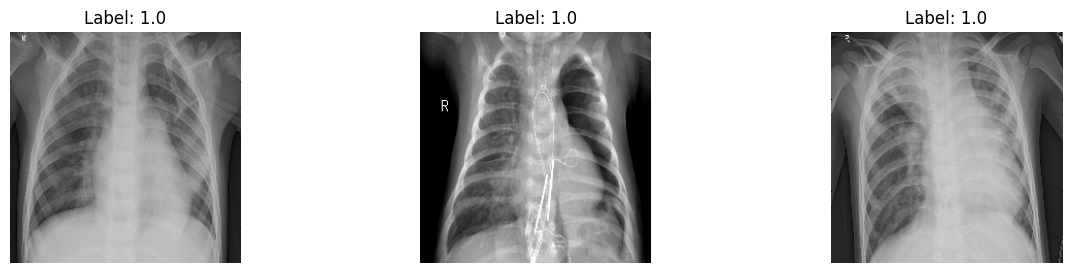

In [ ]:
batch_images, batch_labels = train.next()

num_images_to_plot = 3

fig, axes = plt.subplots(1, num_images_to_plot, figsize=(15, 3))

for i in range(num_images_to_plot):
    img = batch_images[i]
    label = batch_labels[i]

    axes[i].imshow(img.squeeze(), cmap='gray')  # squeeze to remove the channel dimension if grayscale
    axes[i].set_title('Label: {}'.format(label))
    axes[i].axis('off')

plt.show()

# Models Building

## ResNet50 Pretrained Model

In [ ]:
base_model1 = applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model1.trainable = False
keras.applications.resnet50.preprocess_input

ResNet50_model = models.Sequential([
    base_model1,
    layers.GlobalAveragePooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
    ])

ResNet50_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
ResNet50_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 64)                131136    
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 23718913 (90.48 MB)
Trainable params: 131201 (512.50 KB)
Non-trainable params: 23587712 (89.98 MB)
_________

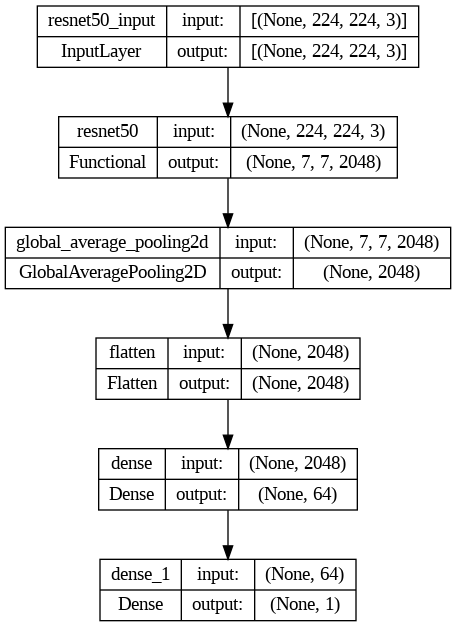

In [ ]:
keras.utils.plot_model(ResNet50_model, "ResNet50_model.png", show_shapes=True)

In [ ]:
history_ResNet50_model = ResNet50_model.fit(train, batch_size=256, epochs=10, validation_data=val)

Epoch 1/10
139/139 [==============================] - 1191s 8s/step - loss: 0.5749 - accuracy: 0.7328 - val_loss: 0.5250 - val_accuracy: 0.7433
Epoch 2/10
139/139 [==============================] - 1110s 8s/step - loss: 0.4935 - accuracy: 0.7467 - val_loss: 0.4525 - val_accuracy: 0.7599
Epoch 3/10
139/139 [==============================] - 1118s 8s/step - loss: 0.4314 - accuracy: 0.7850 - val_loss: 0.4018 - val_accuracy: 0.7905
Epoch 4/10
139/139 [==============================] - 1117s 8s/step - loss: 0.3859 - accuracy: 0.8146 - val_loss: 0.3759 - val_accuracy: 0.8033
Epoch 5/10
139/139 [==============================] - 1170s 8s/step - loss: 0.3638 - accuracy: 0.8276 - val_loss: 0.4123 - val_accuracy: 0.8084
Epoch 6/10
139/139 [==============================] - 1275s 9s/step - loss: 0.3460 - accuracy: 0.8450 - val_loss: 0.3630 - val_accuracy: 0.8225
Epoch 7/10
139/139 [==============================] - 1099s 8s/step - loss: 0.3355 - accuracy: 0.8488 - val_loss: 0.3446 - val_accuracy:

#### Model Evaluation

##### Accuracy

In [ ]:
ResNet50_model_acc = history_ResNet50_model.history['accuracy'][-1:][0]
ResNet50_model_val_acc = history_ResNet50_model.history['val_accuracy'][-1:][0]
print(f'ResNet50 Accuracy: {ResNet50_model_acc}, ResNet50 Validation Accuracy: {ResNet50_model_val_acc}')

ResNet50 Accuracy: 0.8605227470397949, ResNet50 Validation Accuracy: 0.8288633227348328


##### Loss

In [ ]:
ResNet50_model_loss = history_ResNet50_model.history['loss'][-1:][0]
ResNet50_model_val_loss = history_ResNet50_model.history['val_loss'][-1:][0]
print(f'ResNet50 Loss: {ResNet50_model_loss}, ResNet50 Validation Loss: {ResNet50_model_val_loss}')

ResNet50 Loss: 0.3128431737422943, ResNet50 Validation Loss: 0.34630849957466125


##### F1 Score

In [ ]:
train_true_labels_ResNet50 = train.classes
val_true_labels_ResNet50 = val.classes

train_ResNet50_predicted = ResNet50_model.predict(train)
train_ResNet50_binary_predicted = (train_ResNet50_predicted > 0.5).astype(int)

val_ResNet50_predicted = ResNet50_model.predict(val)
val_ResNet50_binary_predicted = (val_ResNet50_predicted > 0.5).astype(int)

25/25 [==============================] - 164s 6s/step
ResNet50 F1 Score: 0.728147803136159
ResNet50 validation F1 Score: 0.696526508226691


In [ ]:
train_ResNet50_f1_score = f1_score(train_true_labels_ResNet50, train_ResNet50_binary_predicted, average='macro')
val_ResNet50_f1_score = f1_score(val_true_labels_ResNet50, val_ResNet50_binary_predicted, average='macro')

print(f'ResNet50 F1 Score: {train_ResNet50_f1_score}')
print(f'ResNet50 validation F1 Score: {val_ResNet50_f1_score}')

ResNet50 F1 Score: 0.5045256469479563
ResNet50 validation F1 Score: 0.4965683388591082


#### Model Performance Visualization

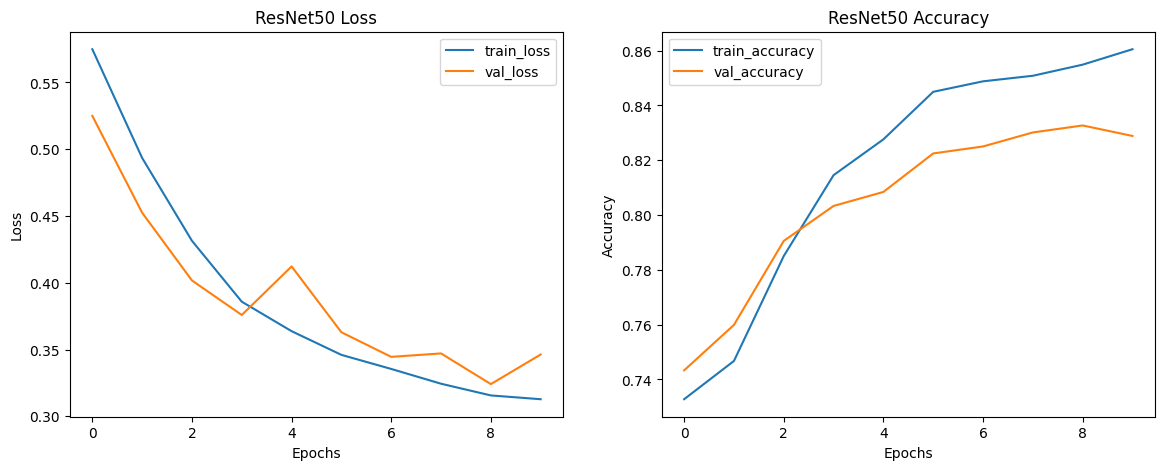

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history_ResNet50_model.history['loss'], label='train_loss')
axes[0].plot(history_ResNet50_model.history['val_loss'], label='val_loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('ResNet50 Loss')
axes[0].legend()

axes[1].plot(history_ResNet50_model.history['accuracy'], label='train_accuracy')
axes[1].plot(history_ResNet50_model.history['val_accuracy'], label='val_accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('ResNet50 Accuracy')
axes[1].legend()

plt.show()

In [ ]:
# visualize layer names and layer indices to see how many layers to freeze
for i, layer in enumerate(base_model1.layers):
   print(i, layer.name)

0 input_4
1 conv1_pad
2 conv1_conv
3 conv1_bn
4 conv1_relu
5 pool1_pad
6 pool1_pool
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_conv
11 conv2_block1_2_bn
12 conv2_block1_2_relu
13 conv2_block1_0_conv
14 conv2_block1_3_conv
15 conv2_block1_0_bn
16 conv2_block1_3_bn
17 conv2_block1_add
18 conv2_block1_out
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_conv
23 conv2_block2_2_bn
24 conv2_block2_2_relu
25 conv2_block2_3_conv
26 conv2_block2_3_bn
27 conv2_block2_add
28 conv2_block2_out
29 conv2_block3_1_conv
30 conv2_block3_1_bn
31 conv2_block3_1_relu
32 conv2_block3_2_conv
33 conv2_block3_2_bn
34 conv2_block3_2_relu
35 conv2_block3_3_conv
36 conv2_block3_3_bn
37 conv2_block3_add
38 conv2_block3_out
39 conv3_block1_1_conv
40 conv3_block1_1_bn
41 conv3_block1_1_relu
42 conv3_block1_2_conv
43 conv3_block1_2_bn
44 conv3_block1_2_relu
45 conv3_block1_0_conv
46 conv3_block1_3_conv
47 conv3_block1_0_bn
48 conv3_block1_3_bn

#### Top Block Unfreezing

In [ ]:
# train the top block, freeze the first 165 layers and unfreeze the rest
for layer in ResNet50_model.layers[165:]:
   layer.trainable = True

# needed of recompile the model for these modifications to take effect
                                                                        # small lr to avoid overfitting
ResNet50_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# to check of freezing layers
for i, layer in enumerate(ResNet50_model.layers):
    print(i, layer.name, layer.trainable)

0 resnet50 False
1 global_average_pooling2d_2 True
2 flatten_4 True
3 dense_8 True
4 dense_9 True


In [ ]:
# retrain the model again (this time fine-tuning the top block alongside the top Dense layers)
start_time_resnet_ft = time.time()
history_ResNet50_model_ft2 = ResNet50_model.fit(train, batch_size=256, epochs=10, validation_data=val)
ResNet50_ft_time = time.time() - start_time_resnet_ft
print(ResNet50_ft_time)

Epoch 1/10
139/139 [==============================] - 108s 731ms/step - loss: 0.2810 - accuracy: 0.8776 - val_loss: 0.3087 - val_accuracy: 0.8506
Epoch 2/10
139/139 [==============================] - 83s 595ms/step - loss: 0.2772 - accuracy: 0.8797 - val_loss: 0.2961 - val_accuracy: 0.8531
Epoch 3/10
139/139 [==============================] - 71s 510ms/step - loss: 0.2743 - accuracy: 0.8799 - val_loss: 0.3075 - val_accuracy: 0.8480
Epoch 4/10
139/139 [==============================] - 72s 521ms/step - loss: 0.2737 - accuracy: 0.8828 - val_loss: 0.2951 - val_accuracy: 0.8506
Epoch 5/10
139/139 [==============================] - 71s 513ms/step - loss: 0.2720 - accuracy: 0.8801 - val_loss: 0.2921 - val_accuracy: 0.8544
Epoch 6/10
139/139 [==============================] - 72s 518ms/step - loss: 0.2701 - accuracy: 0.8813 - val_loss: 0.2874 - val_accuracy: 0.8621
Epoch 7/10
139/139 [==============================] - 70s 503ms/step - loss: 0.2695 - accuracy: 0.8882 - val_loss: 0.2928 - val_a

In [ ]:
ResNet50_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_4 (Flatten)         (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 64)                131136    
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 23718913 (90.48 MB)
Trainable params: 131201 (512.50 KB)
Non-trainable params: 23587712 (89.98 MB)
_______

#### Model Evaluation

##### Accuracy

In [ ]:
ResNet50_model_ft_acc = history_ResNet50_model_ft.history['accuracy'][-1:][0]
ResNet50_model_ft_val_acc = history_ResNet50_model_ft.history['val_accuracy'][-1:][0]
print(f'Fine-tuned ResNet50 Accuracy: {ResNet50_model_ft_acc}, Fine-tuned ResNet50 Validation Accuracy: {ResNet50_model_ft_val_acc}')

Fine-tuned ResNet50 Accuracy: 0.9055880904197693, Fine-tuned ResNet50 Validation Accuracy: 0.8876117467880249


##### Loss

In [ ]:
# GPU possessor
ResNet50_model_ft_loss = history_ResNet50_model_ft2.history['loss'][-1:][0]
ResNet50_model_ft_val_loss = history_ResNet50_model_ft2.history['val_loss'][-1:][0]
print(f'Fine-tuned ResNet50 Loss: {ResNet50_model_ft_loss}, Fine-tuned ResNet50 Validation Loss: {ResNet50_model_ft_val_loss}')

Fine-tuned ResNet50 Loss: 0.22721131145954132, Fine-tuned ResNet50 Validation Loss: 0.22973772883415222


##### F1 Score

In [ ]:
train_ResNet50_model_ft_predicted = ResNet50_model2.predict(train)
train_ResNet50_model_ft_binary_predicted = (train_ResNet50_model_ft_predicted > 0.5).astype(int)

val_ResNet50_model_ft_predicted = ResNet50_model2.predict(val)
val_ResNet50_model_ft_binary_predicted = (val_ResNet50_model_ft_predicted > 0.5).astype(int)

25/25 [==============================] - 10s 381ms/step


In [ ]:
train_ResNet50_model_ft_f1_score = f1_score(train.classes, train_ResNet50_model_ft_binary_predicted, average='macro')
val_ResNet50_model_ft_score = f1_score(val.classes, val_ResNet50_model_ft_binary_predicted, average='macro')

print(f'Fine-tuned ResNet50 F1 Score: {train_ResNet50_model_ft_f1_score}')
print(f'Fine-tuned ResNet50 validation F1 Score: {val_ResNet50_model_ft_score}')

Fine-tuned ResNet50 F1 Score: 0.5073397569801459
Fine-tuned ResNet50 validation F1 Score: 0.4605376344086021


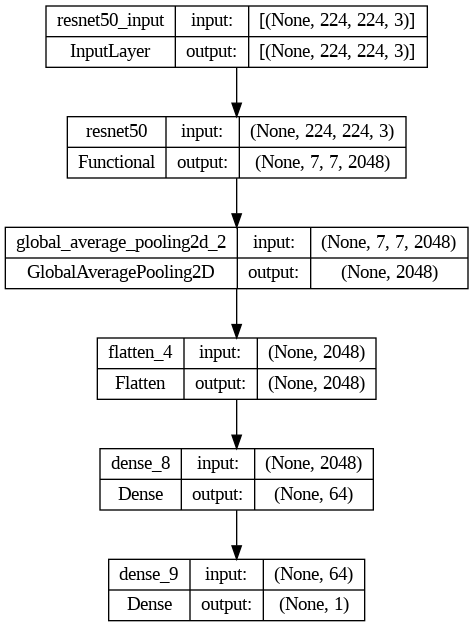

In [ ]:
keras.utils.plot_model(ResNet50_model2, "ResNet50_model_ft2.png", show_shapes=True)

#### Model Performance Visualization

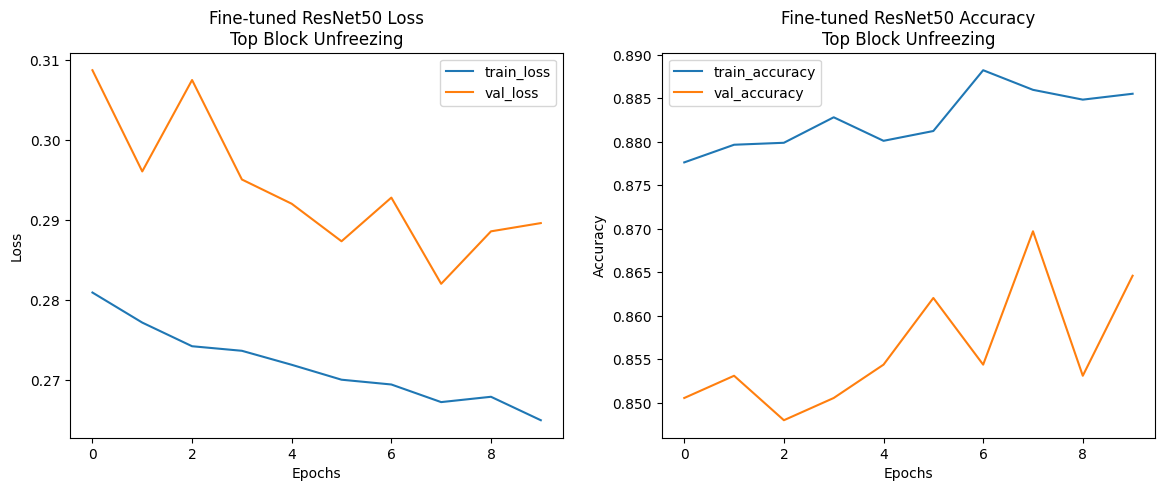

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history_ResNet50_model_ft2.history['loss'], label='train_loss')
axes[0].plot(history_ResNet50_model_ft2.history['val_loss'], label='val_loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Fine-tuned ResNet50 Loss\nTop Block Unfreezing')
axes[0].legend()

axes[1].plot(history_ResNet50_model_ft2.history['accuracy'], label='train_accuracy')
axes[1].plot(history_ResNet50_model_ft2.history['val_accuracy'], label='val_accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Fine-tuned ResNet50 Accuracy\nTop Block Unfreezing')
axes[1].legend()

plt.show()

#### Top 2 Blocks Unfreezing

In [ ]:
# now train the top 2 blocks, freeze the first 155 layers and unfreeze the rest
for layer in ResNet50_model.layers[155:]:
   layer.trainable = True

ResNet50_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
for i, layer in enumerate(ResNet50_model.layers):
    print(i, layer.name, layer.trainable)

0 resnet50 False
1 global_average_pooling2d True
2 flatten_2 True
3 dense_4 True
4 dense_5 True


In [ ]:
start_time_resnet_ft2 = time.time()
history_ResNet50_model_ft2 = ResNet50_model.fit(train, batch_size=256, epochs=10, validation_data=val)
ResNet50_ft2_time = time.time() - start_time_resnet_ft2
print(ResNet50_ft2_time)

Epoch 1/10
139/139 [==============================] - 102s 689ms/step - loss: 0.2960 - accuracy: 0.8713 - val_loss: 0.3185 - val_accuracy: 0.8429
Epoch 2/10
139/139 [==============================] - 87s 628ms/step - loss: 0.2938 - accuracy: 0.8720 - val_loss: 0.3257 - val_accuracy: 0.8391
Epoch 3/10
139/139 [==============================] - 82s 593ms/step - loss: 0.2920 - accuracy: 0.8743 - val_loss: 0.3168 - val_accuracy: 0.8404
Epoch 4/10
139/139 [==============================] - 103s 745ms/step - loss: 0.2914 - accuracy: 0.8725 - val_loss: 0.3131 - val_accuracy: 0.8429
Epoch 5/10
139/139 [==============================] - 84s 602ms/step - loss: 0.2901 - accuracy: 0.8718 - val_loss: 0.3164 - val_accuracy: 0.8455
Epoch 6/10
139/139 [==============================] - 70s 506ms/step - loss: 0.2903 - accuracy: 0.8720 - val_loss: 0.3302 - val_accuracy: 0.8301
Epoch 7/10
139/139 [==============================] - 70s 501ms/step - loss: 0.2882 - accuracy: 0.8761 - val_loss: 0.3179 - val_

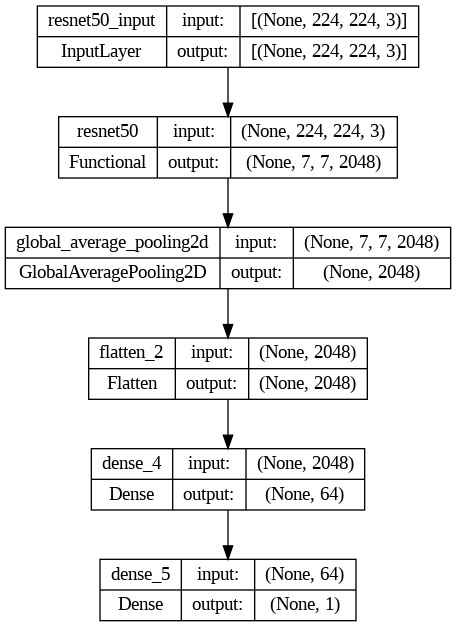

In [ ]:
keras.utils.plot_model(ResNet50_model, "ResNet50_model_ft2.png", show_shapes=True)

In [ ]:
ResNet50_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 64)                131136    
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 23718913 (90.48 MB)
Trainable params: 131201 (512.50 KB)
Non-trainable params: 23587712 (89.98 MB)
_______

#### Model Evaluation

##### Accuracy

In [ ]:
ResNet50_model_ft_acc = history_ResNet50_model_ft2.history['accuracy'][-1:][0]
ResNet50_model_ft_val_acc = history_ResNet50_model_ft2.history['val_accuracy'][-1:][0]
print(f'Fine-tuned ResNet50 Accuracy: {ResNet50_model_ft_acc}, Fine-tuned ResNet50 Validation Accuracy: {ResNet50_model_ft_val_acc}')

Fine-tuned ResNet50 Accuracy: 0.8762956261634827, Fine-tuned ResNet50 Validation Accuracy: 0.8480204343795776


##### Loss

In [ ]:
# GPU possessor
ResNet50_model_ft_loss = history_ResNet50_model_ft2.history['loss'][-1:][0]
ResNet50_model_ft_val_loss = history_ResNet50_model_ft2.history['val_loss'][-1:][0]
print(f'Fine-tuned ResNet50 Loss: {ResNet50_model_ft_loss}, Fine-tuned ResNet50 Validation Loss: {ResNet50_model_ft_val_loss}')

Fine-tuned ResNet50 Loss: 0.2853441834449768, Fine-tuned ResNet50 Validation Loss: 0.3038506805896759


##### F1 Score

In [ ]:
train_ResNet50_model_ft_predicted = ResNet50_model.predict(train)
train_ResNet50_model_ft_binary_predicted = (train_ResNet50_model_ft_predicted > 0.5).astype(int)

val_ResNet50_model_ft_predicted = ResNet50_model.predict(val)
val_ResNet50_model_ft_binary_predicted = (val_ResNet50_model_ft_predicted > 0.5).astype(int)

25/25 [==============================] - 11s 430ms/step


In [ ]:
train_ResNet50_model_ft_f1_score = f1_score(train.classes, train_ResNet50_model_ft_binary_predicted, average='macro')
val_ResNet50_model_ft_score = f1_score(val.classes, val_ResNet50_model_ft_binary_predicted, average='macro')

print(f'Fine-tuned ResNet50 F1 Score: {train_ResNet50_model_ft_f1_score}')
print(f'Fine-tuned ResNet50 validation F1 Score: {val_ResNet50_model_ft_score}')

Fine-tuned ResNet50 F1 Score: 0.5008062085593731
Fine-tuned ResNet50 validation F1 Score: 0.4862005171867494


#### Model Performance Visualization

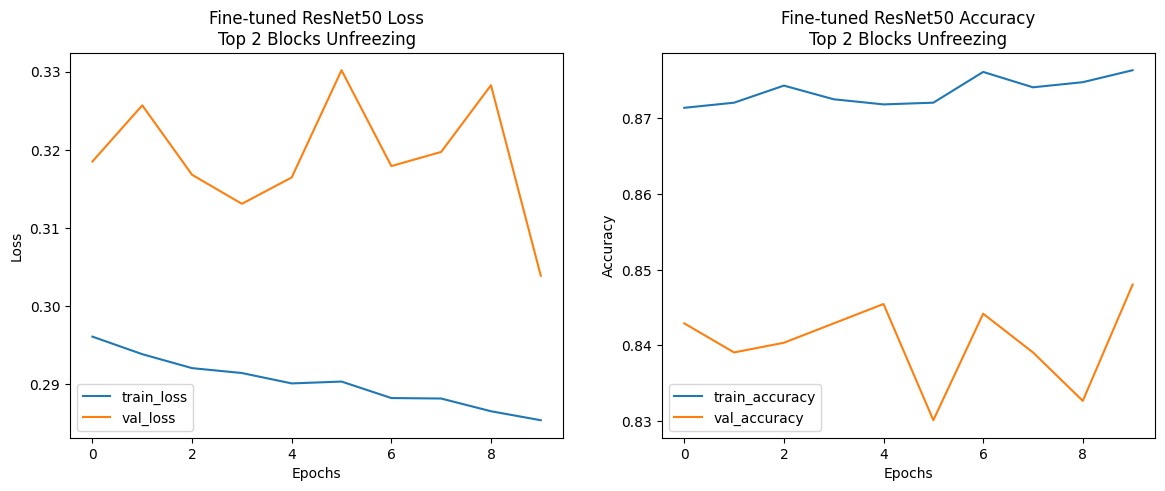

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history_ResNet50_model_ft2.history['loss'], label='train_loss')
axes[0].plot(history_ResNet50_model_ft2.history['val_loss'], label='val_loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Fine-tuned ResNet50 Loss\nTop 2 Blocks Unfreezing')
axes[0].legend()

axes[1].plot(history_ResNet50_model_ft2.history['accuracy'], label='train_accuracy')
axes[1].plot(history_ResNet50_model_ft2.history['val_accuracy'], label='val_accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Fine-tuned ResNet50 Accuracy\nTop 2 Blocks Unfreezing')
axes[1].legend()

plt.show()

### Hyperparameter Tuning

In [ ]:
def build_model(hp):
    base_model = applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Flatten()
    ])

    for i in range(hp.Int('num_dense_layers', min_value=1, max_value=5)):
        model.add(layers.Dense(units=hp.Int(f'units_{i}', values=[32, 64, 128, 256]),
                               activation='relu'))

        if hp.Boolean(f'use_dropout_{i}', default=False):
            model.add(layers.Dropout(rate=hp.Float(f'dropout_rate_{i}', values=[0.2, 0.3, 0.4, 0.5])))

        if hp.Boolean(f'use_batchnorm_{i}', default=False):
            model.add(layers.BatchNormalization())

    model.add(layers.Dense(1, activation='sigmoid'))

    optimizer = hp.Choice('optimizer', values=['adam', 'sgd'])
    if optimizer == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=hp.Choice('adam_learning_rate', values=[1e-2, 1e-3, 1e-4]))
    else:
        opt = tf.keras.optimizers.SGD(learning_rate=hp.Choice('sgd_learning_rate', values=[1e-2, 1e-3, 1e-4]))

    model.compile(optimizer=opt,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
tuner = kt.GridSearch(
    build_model,
    objective='val_accuracy',
    directory='T6_tuner',
    project_name='resnet50_model',
    seed=42
)

In [ ]:
tuner.search(train, epochs=10, validation_data=val)

best_model = tuner.get_best_models(num_models=1)[0]

best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:")
print(best_hyperparameters.values)

Trial 11 Complete [00h 09m 26s]
val_accuracy: 0.7429667711257935

Best val_accuracy So Far: 0.8529411554336548
Total elapsed time: 02h 02m 05s

Search: Running Trial #12

Value             |Best Value So Far |Hyperparameter
1                 |1                 |num_dense_layers
32                |32                |units_0
False             |False             |use_dropout_0
False             |False             |use_batchnorm_0
sgd               |adam              |optimizer
0.0001            |0.001             |adam_learning_rate
0.0001            |None              |sgd_learning_rate

Epoch 1/10
139/139 [==============================] - 60s 411ms/step - loss: 0.6542 - accuracy: 0.6297 - val_loss: 0.5826 - val_accuracy: 0.7430
Epoch 2/10
139/139 [==============================] - 56s 402ms/step - loss: 0.5765 - accuracy: 0.7429 - val_loss: 0.5723 - val_accuracy: 0.7430
Epoch 3/10
139/139 [==============================] - 55s 399ms/step - loss: 0.5722 - accuracy: 0.7429 - val_loss: 0.

#### Model Building

In [ ]:
base_model1 = applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model1.trainable = False
keras.applications.resnet50.preprocess_input

ResNet50_model_hp = models.Sequential([
    base_model1,
    layers.GlobalAveragePooling2D(),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
    ])

ResNet50_model_hp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
ResNet50_model_hp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 32)                65568     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 23653313 (90.23 MB)
Trainable params: 65601 (256.25 KB)
Non-trainable params: 23587712 (89.98 MB)
__________

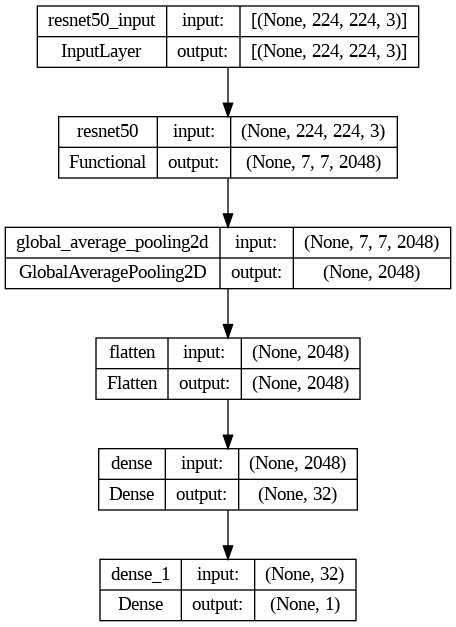

In [ ]:
keras.utils.plot_model(ResNet50_model_hp, "ResNet50_model_hp.png", show_shapes=True)

In [ ]:
start_time_resnet_hp = time.time()
history_ResNet50_model_hp = ResNet50_model_hp.fit(train, batch_size=256, epochs=10, validation_data=val)
ResNet50_hp_time = time.time() - start_time_resnet_hp
print(ResNet50_hp_time)

Epoch 1/10
139/139 [==============================] - 2012s 14s/step - loss: 0.5649 - accuracy: 0.7402 - val_loss: 0.5453 - val_accuracy: 0.7430
Epoch 2/10
139/139 [==============================] - 1053s 8s/step - loss: 0.5237 - accuracy: 0.7429 - val_loss: 0.4927 - val_accuracy: 0.7430
Epoch 3/10
139/139 [==============================] - 1388s 10s/step - loss: 0.4678 - accuracy: 0.7429 - val_loss: 0.4460 - val_accuracy: 0.7430
Epoch 4/10
139/139 [==============================] - 1017s 7s/step - loss: 0.4190 - accuracy: 0.7713 - val_loss: 0.4048 - val_accuracy: 0.7903
Epoch 5/10
139/139 [==============================] - 1069s 8s/step - loss: 0.3883 - accuracy: 0.8090 - val_loss: 0.3853 - val_accuracy: 0.7992
Epoch 6/10
139/139 [==============================] - 1061s 8s/step - loss: 0.3713 - accuracy: 0.8288 - val_loss: 0.3871 - val_accuracy: 0.8069
Epoch 7/10
139/139 [==============================] - 1050s 8s/step - loss: 0.3649 - accuracy: 0.8358 - val_loss: 0.3635 - val_accurac

#### Model Evaluation

##### Accuracy

In [ ]:
# resnet hp
ResNet50_hp_model_acc = history_ResNet50_model_hp.history['accuracy'][-1:][0]
ResNet50_hp_model_val_acc = history_ResNet50_model_hp.history['val_accuracy'][-1:][0]
print(f'ResNet50 Accuracy: {ResNet50_hp_model_acc}, ResNet50 Validation Accuracy: {ResNet50_hp_model_val_acc}')

ResNet50 Accuracy: 0.8486693501472473, ResNet50 Validation Accuracy: 0.8171355724334717


##### Loss

In [ ]:
ResNet50_hp_model_loss = history_ResNet50_model_hp.history['loss'][-1:][0]
ResNet50_hp_model_val_loss = history_ResNet50_model_hp.history['val_loss'][-1:][0]
print(f'ResNet50 Loss: {ResNet50_hp_model_loss}, ResNet50 Validation Loss: {ResNet50_hp_model_val_loss}')

ResNet50 Loss: 0.33663812279701233, ResNet50 Validation Loss: 0.3433179557323456


##### F1 Score

In [ ]:
train_true_labels_ResNet50 = train.classes
val_true_labels_ResNet50 = val.classes

train_ResNet50_hp_predicted = ResNet50_model_hp.predict(train)
train_ResNet50_hp_binary_predicted = (train_ResNet50_hp_predicted > 0.5).astype(int)

val_ResNet50_hp_predicted = ResNet50_model_hp.predict(val)
val_ResNet50_hp_binary_predicted = (val_ResNet50_hp_predicted > 0.5).astype(int)

25/25 [==============================] - 153s 6s/step


In [ ]:
train_ResNet50_hp_f1_score = f1_score(train_true_labels_ResNet50, train_ResNet50_hp_binary_predicted, average='macro')
val_ResNet50_hp_f1_score = f1_score(val_true_labels_ResNet50, val_ResNet50_hp_binary_predicted, average='macro')

print(f'ResNet50 hp F1 Score: {train_ResNet50_hp_f1_score}')
print(f'ResNet50 hp validation F1 Score: {val_ResNet50_hp_f1_score}')

ResNet50 hp F1 Score: 0.49542684578436896
ResNet50 hp validation F1 Score: 0.5107304479878512


#### Model Performance Visualization

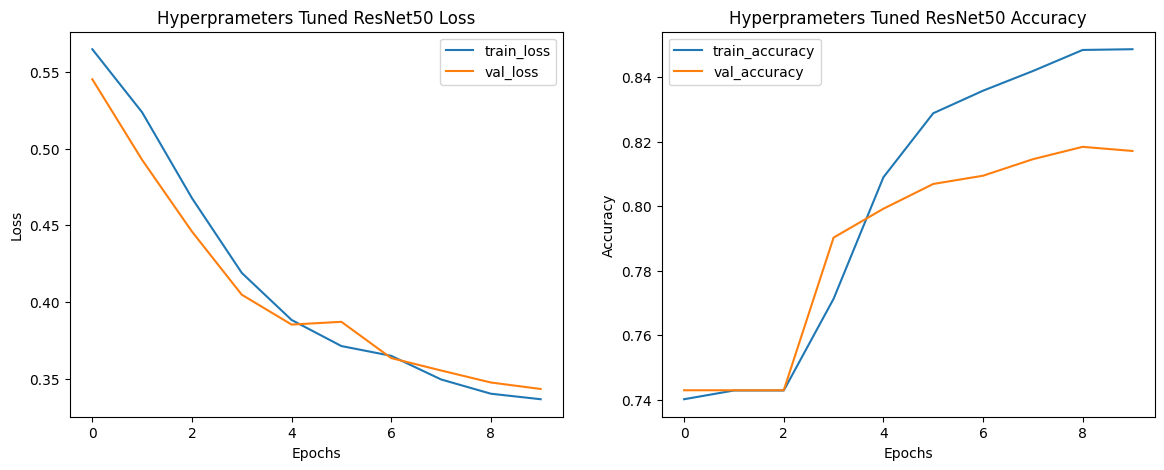

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history_ResNet50_model_hp.history['loss'], label='train_loss')
axes[0].plot(history_ResNet50_model_hp.history['val_loss'], label='val_loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Tuned Hyperparameters ResNet50 Loss')
axes[0].legend()

axes[1].plot(history_ResNet50_model_hp.history['accuracy'], label='train_accuracy')
axes[1].plot(history_ResNet50_model_hp.history['val_accuracy'], label='val_accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Tuned Hyperparameters ResNet50 Accuracy')
axes[1].legend()

plt.show()

## Regular CNN Model

In [ ]:
scratch_cnn_model = models.Sequential([
        layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(224, 224, 3)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

scratch_cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
scratch_cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 222, 222, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 107, 107, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 53, 53, 64)        0         
 g2D)                                                   

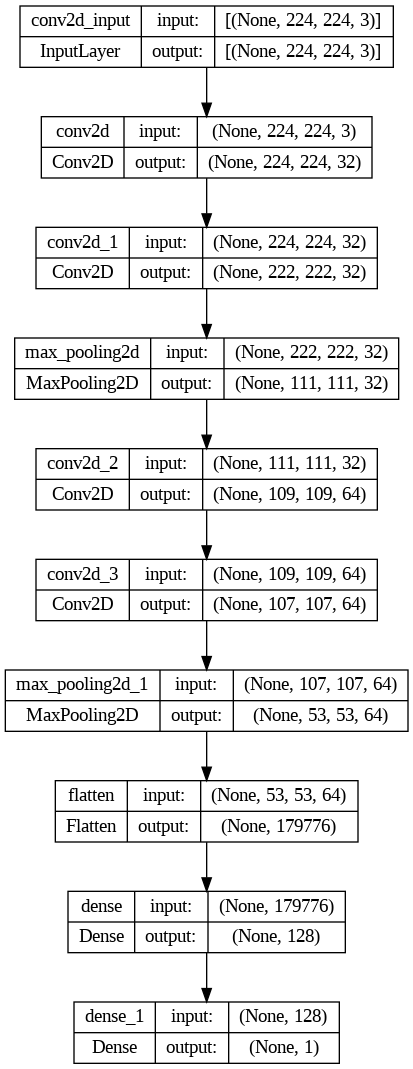

In [ ]:
keras.utils.plot_model(scratch_cnn_model, "scratch_cnn_model.png", show_shapes=True)

### acc: 0.9926, val_accuracy: 0.9553 **accurate** but with overfitting

In [ ]:
start_time_cnn = time.time()
history_scratch_cnn_model = scratch_cnn_model.fit(train, batch_size=256, epochs=10, validation_data=val)
cnn_time = time.time() - start_time_cnn
print(cnn_time)

Epoch 1/10
139/139 [==============================] - 1508s 11s/step - loss: 0.4007 - accuracy: 0.8371 - val_loss: 0.2815 - val_accuracy: 0.8838
Epoch 2/10
139/139 [==============================] - 1270s 9s/step - loss: 0.1587 - accuracy: 0.9396 - val_loss: 0.1649 - val_accuracy: 0.9323
Epoch 3/10
139/139 [==============================] - 1273s 9s/step - loss: 0.0978 - accuracy: 0.9621 - val_loss: 0.2194 - val_accuracy: 0.9132
Epoch 4/10
139/139 [==============================] - 1265s 9s/step - loss: 0.0692 - accuracy: 0.9757 - val_loss: 0.1478 - val_accuracy: 0.9451
Epoch 5/10
139/139 [==============================] - 1266s 9s/step - loss: 0.0503 - accuracy: 0.9808 - val_loss: 0.1273 - val_accuracy: 0.9515
Epoch 6/10
139/139 [==============================] - 1272s 9s/step - loss: 0.0394 - accuracy: 0.9851 - val_loss: 0.2040 - val_accuracy: 0.9323
Epoch 7/10
139/139 [==============================] - 1245s 9s/step - loss: 0.0299 - accuracy: 0.9892 - val_loss: 0.2195 - val_accuracy

### Model Evaluation

#### Accuracy

In [ ]:
scratch_cnn_model_acc = history_scratch_cnn_model.history['accuracy'][-1:][0]
scratch_cnn_model_val_acc = history_scratch_cnn_model.history['val_accuracy'][-1:][0]
print(f'CNN Accuracy: {scratch_cnn_model_acc}, CNN Validation Accuracy: {scratch_cnn_model_val_acc}')

CNN Accuracy: 0.9925642013549805, CNN Validation Accuracy: 0.9553001523017883


#### Loss

In [ ]:
scratch_cnn_model_loss = history_scratch_cnn_model.history['loss'][-1:][0]
scratch_cnn_model_val_loss = history_scratch_cnn_model.history['val_loss'][-1:][0]
print(f'CNN Loss: {scratch_cnn_model_loss}, CNN Validation Loss: {scratch_cnn_model_val_loss}')

CNN Loss: 0.021562034264206886, CNN Validation Loss: 0.18040113151073456


#### F1 Score

In [ ]:
train_true_labels_scratch_cnn_model = train.classes
val_true_labels_scratch_cnn_model = val.classes

train_scratch_cnn_model_predicted = scratch_cnn_model.predict(train)
train_scratch_cnn_model_binary_predicted = (train_scratch_cnn_model_predicted > 0.5).astype(int)

val_scratch_cnn_model_predicted = scratch_cnn_model.predict(val)
val_scratch_cnn_model_binary_predicted = (val_scratch_cnn_model_predicted > 0.5).astype(int)

25/25 [==============================] - 63s 2s/step


In [ ]:
train_scratch_cnn_model_f1_score = f1_score(train_true_labels_scratch_cnn_model, train_scratch_cnn_model_binary_predicted, average='macro')
val_scratch_cnn_model_f1_score = f1_score(val_true_labels_scratch_cnn_model, val_scratch_cnn_model_binary_predicted, average='macro')

print(f'CNN F1 Score: {train_scratch_cnn_model_f1_score}')
print(f'CNN validation F1 Score: {val_scratch_cnn_model_f1_score}')

CNN F1 Score: 0.5171376687443383
CNN validation F1 Score: 0.5120872810795292


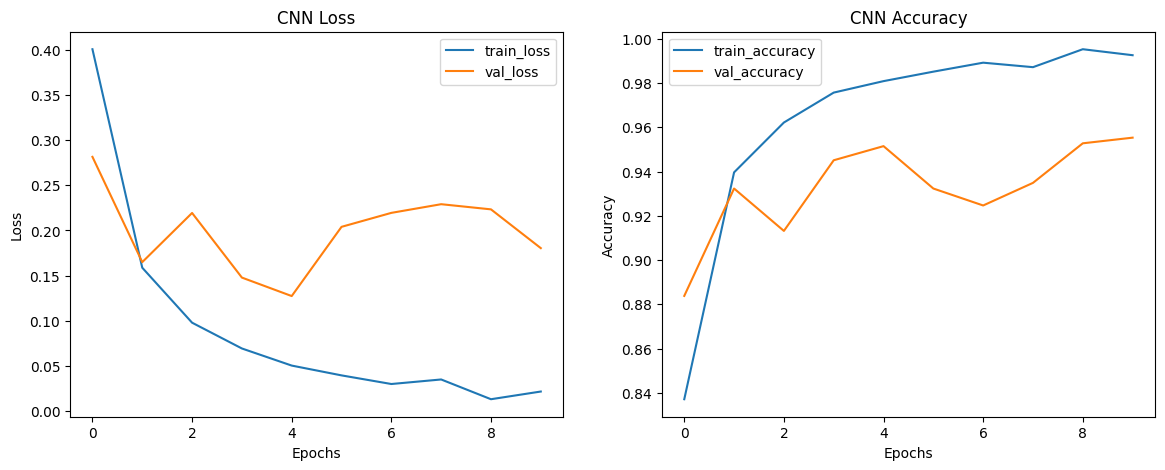

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history_scratch_cnn_model.history['loss'], label='train_loss')
axes[0].plot(history_scratch_cnn_model.history['val_loss'], label='val_loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('CNN Loss')
axes[0].legend()

axes[1].plot(history_scratch_cnn_model.history['accuracy'], label='train_accuracy')
axes[1].plot(history_scratch_cnn_model.history['val_accuracy'], label='val_accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('CNN Accuracy')
axes[1].legend()

plt.show()

## Regularization

### train/val balanced acc: 0.9904, val_accuracy: 0.9371 **accurate** but still there is overfitting

In [ ]:
start_time_cnn_b = time.time()
history_scratch_cnn_model = scratch_cnn_model.fit(balanced_train, batch_size=256, epochs=10, validation_data=balanced_val)
cnn_b_time = time.time() - start_time_cnn_b
print(cnn_b_time)

Epoch 1/10
206/206 [==============================] - 879s 4s/step - loss: 0.3251 - accuracy: 0.8676 - val_loss: 0.1916 - val_accuracy: 0.9207
Epoch 2/10
206/206 [==============================] - 84s 406ms/step - loss: 0.1166 - accuracy: 0.9541 - val_loss: 0.1936 - val_accuracy: 0.9276
Epoch 3/10
206/206 [==============================] - 83s 401ms/step - loss: 0.0792 - accuracy: 0.9669 - val_loss: 0.1908 - val_accuracy: 0.9293
Epoch 4/10
206/206 [==============================] - 83s 401ms/step - loss: 0.0426 - accuracy: 0.9854 - val_loss: 0.1804 - val_accuracy: 0.9483
Epoch 5/10
206/206 [==============================] - 82s 399ms/step - loss: 0.0206 - accuracy: 0.9927 - val_loss: 0.1755 - val_accuracy: 0.9474
Epoch 6/10
206/206 [==============================] - 87s 420ms/step - loss: 0.0147 - accuracy: 0.9938 - val_loss: 0.3318 - val_accuracy: 0.9267
Epoch 7/10
206/206 [==============================] - 82s 399ms/step - loss: 0.0206 - accuracy: 0.9933 - val_loss: 0.3758 - val_accu

#### F1 Score

In [ ]:
train_true_labels_scratch_cnn_model = train.classes
val_true_labels_scratch_cnn_model = val.classes

train_scratch_cnn_model_predicted = scratch_cnn_model.predict(train)
train_scratch_cnn_model_binary_predicted = (train_scratch_cnn_model_predicted > 0.5).astype(int)

val_scratch_cnn_model_predicted = scratch_cnn_model.predict(val)
val_scratch_cnn_model_binary_predicted = (val_scratch_cnn_model_predicted > 0.5).astype(int)

25/25 [==============================] - 555s 23s/step


In [ ]:
train_scratch_cnn_model_f1_score = f1_score(train_true_labels_scratch_cnn_model, train_scratch_cnn_model_binary_predicted, average='macro')
val_scratch_cnn_model_f1_score = f1_score(val_true_labels_scratch_cnn_model, val_scratch_cnn_model_binary_predicted, average='macro')

print(f'CNN F1 Score: {train_scratch_cnn_model_f1_score}')
print(f'CNN validation F1 Score: {val_scratch_cnn_model_f1_score}')

CNN F1 Score: 0.3762936019797134
CNN validation F1 Score: 0.37894465407162714


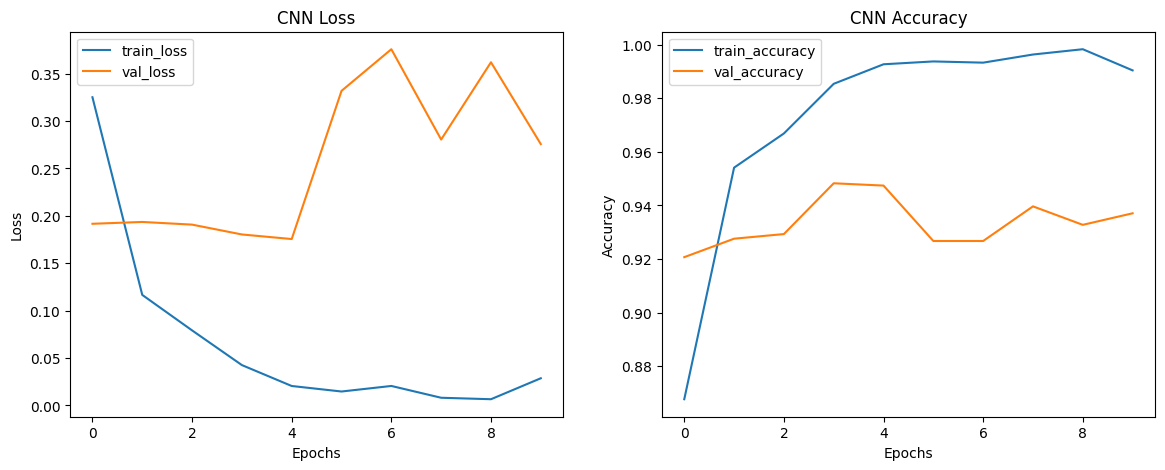

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history_scratch_cnn_model.history['loss'], label='train_loss')
axes[0].plot(history_scratch_cnn_model.history['val_loss'], label='val_loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('CNN Loss')
axes[0].legend()

axes[1].plot(history_scratch_cnn_model.history['accuracy'], label='train_accuracy')
axes[1].plot(history_scratch_cnn_model.history['val_accuracy'], label='val_accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('CNN Accuracy')
axes[1].legend()

plt.show()

### train/val generator_aug acc: 0.8704, val_accuracy: 0.8198 still overfitting

In [ ]:
start_time_cnn_gen = time.time()
history_scratch_cnn_model = scratch_cnn_model.fit(train_generator_aug, batch_size=256, epochs=10, validation_data=val_generator_aug)
cnn_gen_time = time.time() - start_time_cnn_gen
print(cnn_gen_time)

Epoch 1/10
206/206 [==============================] - 181s 871ms/step - loss: 10.9647 - accuracy: 0.7394 - val_loss: 0.4812 - val_accuracy: 0.8078
Epoch 2/10
206/206 [==============================] - 182s 885ms/step - loss: 0.7249 - accuracy: 0.7812 - val_loss: 0.4571 - val_accuracy: 0.8284
Epoch 3/10
206/206 [==============================] - 185s 899ms/step - loss: 0.4257 - accuracy: 0.8136 - val_loss: 0.6217 - val_accuracy: 0.7948
Epoch 4/10
206/206 [==============================] - 181s 881ms/step - loss: 0.4116 - accuracy: 0.8236 - val_loss: 0.4285 - val_accuracy: 0.8207
Epoch 5/10
206/206 [==============================] - 181s 880ms/step - loss: 0.3954 - accuracy: 0.8280 - val_loss: 0.3961 - val_accuracy: 0.8388
Epoch 6/10
206/206 [==============================] - 183s 887ms/step - loss: 0.3425 - accuracy: 0.8456 - val_loss: 0.4500 - val_accuracy: 0.7586
Epoch 7/10
206/206 [==============================] - 185s 898ms/step - loss: 0.3401 - accuracy: 0.8572 - val_loss: 0.3871 

### Model Evaluation

#### Accuracy

In [ ]:
scratch_cnn_model_acc = history_scratch_cnn_model.history['accuracy'][-1:][0]
scratch_cnn_model_val_acc = history_scratch_cnn_model.history['val_accuracy'][-1:][0]
print(f'CNN Accuracy: {scratch_cnn_model_acc}, CNN Validation Accuracy: {scratch_cnn_model_val_acc}')

CNN Accuracy: 0.8703844547271729, CNN Validation Accuracy: 0.8198275566101074


#### Loss

In [ ]:
scratch_cnn_model_loss = history_scratch_cnn_model.history['loss'][-1:][0]
scratch_cnn_model_val_loss = history_scratch_cnn_model.history['val_loss'][-1:][0]
print(f'CNN Loss: {scratch_cnn_model_loss}, CNN Validation Loss: {scratch_cnn_model_val_loss}')

CNN Loss: 0.3217589557170868, CNN Validation Loss: 0.40989577770233154


#### F1 Score

In [ ]:
train_true_labels_scratch_cnn_model = train.classes
val_true_labels_scratch_cnn_model = val.classes

train_scratch_cnn_model_predicted = scratch_cnn_model.predict(train)
train_scratch_cnn_model_binary_predicted = (train_scratch_cnn_model_predicted > 0.5).astype(int)

val_scratch_cnn_model_predicted = scratch_cnn_model.predict(val)
val_scratch_cnn_model_binary_predicted = (val_scratch_cnn_model_predicted > 0.5).astype(int)

25/25 [==============================] - 9s 350ms/step


In [ ]:
train_scratch_cnn_model_f1_score = f1_score(train_true_labels_scratch_cnn_model, train_scratch_cnn_model_binary_predicted, average='macro')
val_scratch_cnn_model_f1_score = f1_score(val_true_labels_scratch_cnn_model, val_scratch_cnn_model_binary_predicted, average='macro')

print(f'CNN F1 Score: {train_scratch_cnn_model_f1_score}')
print(f'CNN validation F1 Score: {val_scratch_cnn_model_f1_score}')

CNN F1 Score: 0.4263185108583247
CNN validation F1 Score: 0.4263736263736264


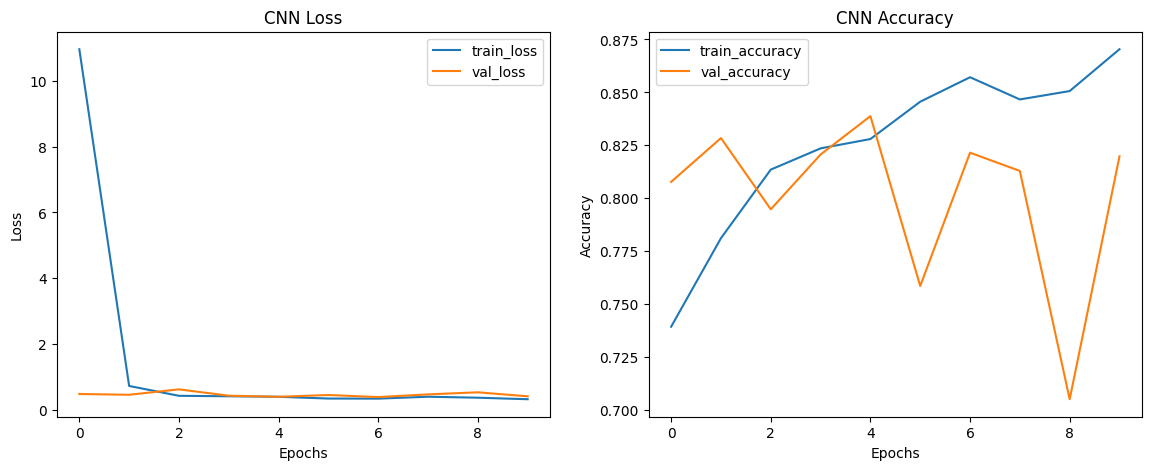

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history_scratch_cnn_model.history['loss'], label='train_loss')
axes[0].plot(history_scratch_cnn_model.history['val_loss'], label='val_loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('CNN Loss')
axes[0].legend()

axes[1].plot(history_scratch_cnn_model.history['accuracy'], label='train_accuracy')
axes[1].plot(history_scratch_cnn_model.history['val_accuracy'], label='val_accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('CNN Accuracy')
axes[1].legend()

plt.show()

### train/val generator acc: 0.8936, val_accuracy: 0.8621 but still overfitting

In [ ]:
start_time_cnn_gen = time.time()
history_scratch_cnn_model = scratch_cnn_model.fit(train_generator, batch_size=256, epochs=10, validation_data=val_generator)
cnn_gen_time = time.time() - start_time_cnn_gen
print(cnn_gen_time)

Epoch 1/10
139/139 [==============================] - 147s 1s/step - loss: 24.1046 - accuracy: 0.7402 - val_loss: 0.4378 - val_accuracy: 0.7791
Epoch 2/10
139/139 [==============================] - 136s 980ms/step - loss: 0.4247 - accuracy: 0.8159 - val_loss: 0.3839 - val_accuracy: 0.8046
Epoch 3/10
139/139 [==============================] - 135s 973ms/step - loss: 0.3406 - accuracy: 0.8562 - val_loss: 0.3142 - val_accuracy: 0.8480
Epoch 4/10
139/139 [==============================] - 135s 971ms/step - loss: 0.3129 - accuracy: 0.8709 - val_loss: 0.4147 - val_accuracy: 0.8174
Epoch 5/10
139/139 [==============================] - 135s 970ms/step - loss: 0.2963 - accuracy: 0.8790 - val_loss: 0.3268 - val_accuracy: 0.8557
Epoch 6/10
139/139 [==============================] - 136s 976ms/step - loss: 0.2991 - accuracy: 0.8781 - val_loss: 0.3198 - val_accuracy: 0.8633
Epoch 7/10
139/139 [==============================] - 135s 970ms/step - loss: 0.2898 - accuracy: 0.8804 - val_loss: 0.3269 - v

### Model Evaluation

#### Accuracy

In [ ]:
scratch_cnn_model_acc = history_scratch_cnn_model.history['accuracy'][-1:][0]
scratch_cnn_model_val_acc = history_scratch_cnn_model.history['val_accuracy'][-1:][0]
print(f'CNN Accuracy: {scratch_cnn_model_acc}, CNN Validation Accuracy: {scratch_cnn_model_val_acc}')

CNN Accuracy: 0.8936457633972168, CNN Validation Accuracy: 0.8620689511299133


#### Loss

In [ ]:
scratch_cnn_model_loss = history_scratch_cnn_model.history['loss'][-1:][0]
scratch_cnn_model_val_loss = history_scratch_cnn_model.history['val_loss'][-1:][0]
print(f'CNN Loss: {scratch_cnn_model_loss}, CNN Validation Loss: {scratch_cnn_model_val_loss}')

CNN Loss: 0.25621965527534485, CNN Validation Loss: 0.3002166152000427


#### F1 Score

In [ ]:
train_true_labels_scratch_cnn_model = train.classes
val_true_labels_scratch_cnn_model = val.classes

train_scratch_cnn_model_predicted = scratch_cnn_model.predict(train)
train_scratch_cnn_model_binary_predicted = (train_scratch_cnn_model_predicted > 0.5).astype(int)

val_scratch_cnn_model_predicted = scratch_cnn_model.predict(val)
val_scratch_cnn_model_binary_predicted = (val_scratch_cnn_model_predicted > 0.5).astype(int)

25/25 [==============================] - 10s 379ms/step


In [ ]:
train_scratch_cnn_model_f1_score = f1_score(train_true_labels_scratch_cnn_model, train_scratch_cnn_model_binary_predicted, average='macro')
val_scratch_cnn_model_f1_score = f1_score(val_true_labels_scratch_cnn_model, val_scratch_cnn_model_binary_predicted, average='macro')

print(f'CNN F1 Score: {train_scratch_cnn_model_f1_score}')
print(f'CNN validation F1 Score: {val_scratch_cnn_model_f1_score}')

CNN F1 Score: 0.20491080974239365
CNN validation F1 Score: 0.20426829268292684


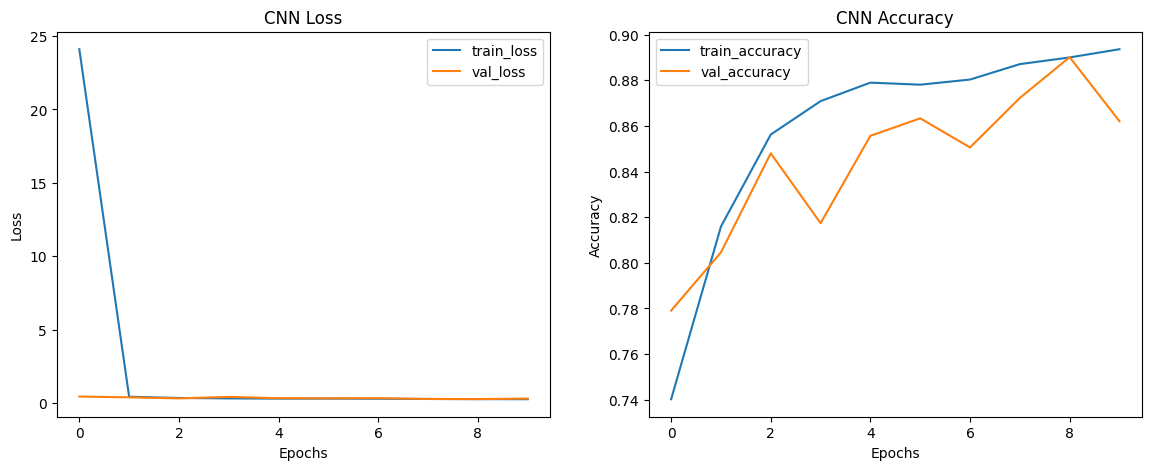

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history_scratch_cnn_model.history['loss'], label='train_loss')
axes[0].plot(history_scratch_cnn_model.history['val_loss'], label='val_loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('CNN Loss')
axes[0].legend()

axes[1].plot(history_scratch_cnn_model.history['accuracy'], label='train_accuracy')
axes[1].plot(history_scratch_cnn_model.history['val_accuracy'], label='val_accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('CNN Accuracy')
axes[1].legend()

plt.show()

### Data Augmentation & Dropout

In [ ]:
scratch_cnn_model_d = models.Sequential([
        layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(224, 224, 3)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.2),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

scratch_cnn_model_d.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
scratch_cnn_model_d.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 conv2d_5 (Conv2D)           (None, 222, 222, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 111, 111, 32)      0         
                                                                 
 conv2d_6 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 107, 107, 64)      36928     
                                                      

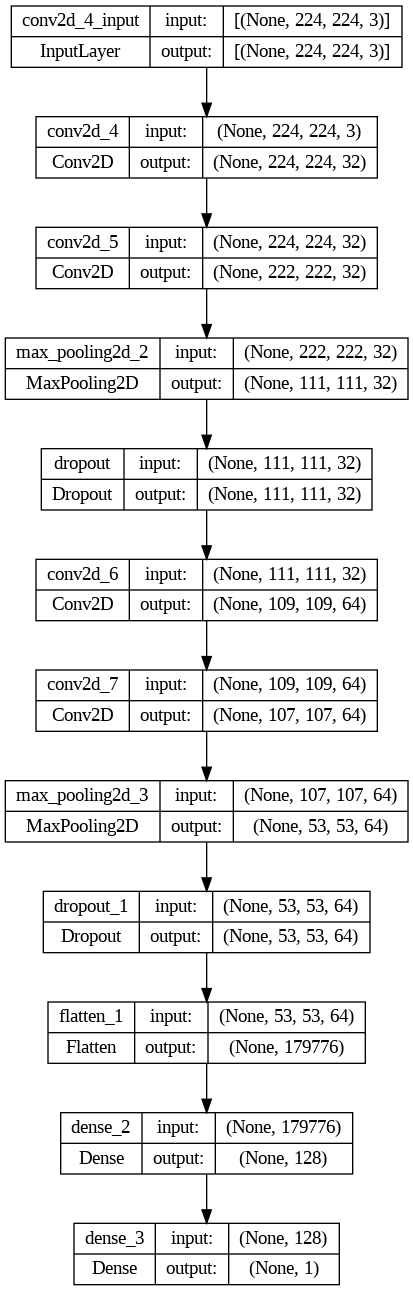

In [ ]:
keras.utils.plot_model(scratch_cnn_model_d, "scratch_cnn_model_d.png", show_shapes=True)

### dropout train/val balanced aug acc: 0.8938, val_accuracy: 0.8707 **least overfitting**

In [ ]:
start_time_cnn_b2 = time.time()
history_scratch_cnn_model_d = scratch_cnn_model_d.fit(train_generator_aug, batch_size=256, epochs=10, validation_data=val_generator_aug)
cnn_b2_time = time.time() - start_time_cnn_b2
print(cnn_b2_time)

Epoch 1/10
206/206 [==============================] - 194s 926ms/step - loss: 20.8648 - accuracy: 0.7143 - val_loss: 0.4932 - val_accuracy: 0.8034
Epoch 2/10
206/206 [==============================] - 189s 920ms/step - loss: 0.4382 - accuracy: 0.8025 - val_loss: 0.4705 - val_accuracy: 0.8026
Epoch 3/10
206/206 [==============================] - 190s 921ms/step - loss: 0.3702 - accuracy: 0.8578 - val_loss: 0.4010 - val_accuracy: 0.8284
Epoch 4/10
206/206 [==============================] - 191s 927ms/step - loss: 0.3477 - accuracy: 0.8655 - val_loss: 0.3811 - val_accuracy: 0.8302
Epoch 5/10
206/206 [==============================] - 192s 931ms/step - loss: 0.3076 - accuracy: 0.8797 - val_loss: 0.3596 - val_accuracy: 0.8491
Epoch 6/10
206/206 [==============================] - 192s 933ms/step - loss: 0.2880 - accuracy: 0.8876 - val_loss: 0.5417 - val_accuracy: 0.7060
Epoch 7/10
206/206 [==============================] - 192s 934ms/step - loss: 0.2823 - accuracy: 0.8889 - val_loss: 0.3910 

#### F1 Score

In [ ]:
train_scratch_cnn_model_d_predicted = scratch_cnn_model_d.predict(balanced_train)
train_scratch_cnn_model_d_binary_predicted = (train_scratch_cnn_model_d_predicted > 0.5).astype(int)

val_scratch_cnn_model_d_predicted = scratch_cnn_model_d.predict(balanced_val)
val_scratch_cnn_model_d_binary_predicted = (val_scratch_cnn_model_d_predicted > 0.5).astype(int)

37/37 [==============================] - 18s 486ms/step


In [ ]:
train_scratch_cnn_model_reg2_f1_score = f1_score(balanced_train.classes, train_scratch_cnn_model_d_binary_predicted, average='macro')
val_scratch_cnn_model_reg2_f1_score = f1_score(balanced_val.classes, val_scratch_cnn_model_d_binary_predicted, average='macro')

print(f'CNN F1 Score: {train_scratch_cnn_model_reg2_f1_score}')
print(f'CNN validation F1 Score: {val_scratch_cnn_model_reg2_f1_score}')

CNN F1 Score: 0.33309687880016214
CNN validation F1 Score: 0.3329499712478436


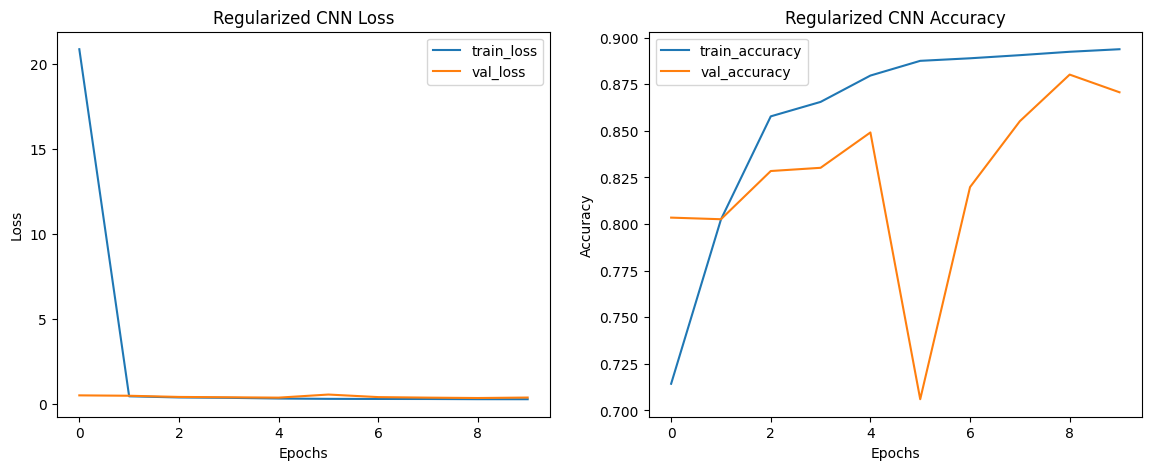

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history_scratch_cnn_model_d.history['loss'], label='train_loss')
axes[0].plot(history_scratch_cnn_model_d.history['val_loss'], label='val_loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Regularized CNN Loss')
axes[0].legend()

axes[1].plot(history_scratch_cnn_model_d.history['accuracy'], label='train_accuracy')
axes[1].plot(history_scratch_cnn_model_d.history['val_accuracy'], label='val_accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Regularized CNN Accuracy')
axes[1].legend()

plt.show()

### dropout with balaned train/val acc: 0.9929, val_accuracy: 0.9362 **accurate** but still overfitting

In [ ]:
start_time_cnn_reg2 = time.time()
history_scratch_cnn_model_reg2 = scratch_cnn_model_reg2.fit(balanced_train, batch_size=256, epochs=10, validation_data=balanced_val)
reg2_cnn_time = time.time() - start_time_cnn_reg2
print(reg2_cnn_time)

Epoch 1/10
206/206 [==============================] - 1133s 5s/step - loss: 0.3533 - accuracy: 0.8640 - val_loss: 0.3146 - val_accuracy: 0.8828
Epoch 2/10
206/206 [==============================] - 80s 386ms/step - loss: 0.1417 - accuracy: 0.9468 - val_loss: 0.2839 - val_accuracy: 0.8784
Epoch 3/10
206/206 [==============================] - 81s 392ms/step - loss: 0.1122 - accuracy: 0.9559 - val_loss: 0.3167 - val_accuracy: 0.8793
Epoch 4/10
206/206 [==============================] - 83s 404ms/step - loss: 0.0866 - accuracy: 0.9682 - val_loss: 0.1559 - val_accuracy: 0.9517
Epoch 5/10
206/206 [==============================] - 80s 390ms/step - loss: 0.1411 - accuracy: 0.9523 - val_loss: 0.1961 - val_accuracy: 0.9241
Epoch 6/10
206/206 [==============================] - 80s 389ms/step - loss: 0.0725 - accuracy: 0.9730 - val_loss: 0.2287 - val_accuracy: 0.9224
Epoch 7/10
206/206 [==============================] - 83s 404ms/step - loss: 0.0464 - accuracy: 0.9833 - val_loss: 0.1869 - val_acc

### Model Evaluation

#### Accuracy

In [ ]:
scratch_cnn_model_reg2_acc = history_scratch_cnn_model_reg2.history['accuracy'][-1:][0]
scratch_cnn_model_reg2_val_acc = history_scratch_cnn_model_reg2.history['val_accuracy'][-1:][0]
print(f'Regularized CNN Accuracy: {scratch_cnn_model_reg2_acc}, Regularized CNN Validation Accuracy: {scratch_cnn_model_reg2_val_acc}')

Regularized CNN Accuracy: 0.9928582310676575, Regularized CNN Validation Accuracy: 0.9362068772315979


#### Loss

In [ ]:
scratch_cnn_model_reg2_loss = history_scratch_cnn_model_reg2.history['loss'][-1:][0]
scratch_cnn_model_reg2_val_loss = history_scratch_cnn_model_reg2.history['val_loss'][-1:][0]
print(f'Regularized CNN Loss: {scratch_cnn_model_reg2_loss}, Regularized CNN Validation Loss: {scratch_cnn_model_reg2_val_loss}')

Regularized CNN Loss: 0.020057398825883865, Regularized CNN Validation Loss: 0.26656028628349304


#### F1 Score

In [ ]:
train_scratch_cnn_model_reg2_predicted = scratch_cnn_model_reg2.predict(balanced_train)
train_scratch_cnn_model_reg2_binary_predicted = (train_scratch_cnn_model_reg2_predicted > 0.5).astype(int)

val_scratch_cnn_model_reg2_predicted = scratch_cnn_model_reg2.predict(balanced_val)
val_scratch_cnn_model_reg2_binary_predicted = (val_scratch_cnn_model_reg2_predicted > 0.5).astype(int)

37/37 [==============================] - 23s 610ms/step


In [ ]:
train_scratch_cnn_model_reg2_f1_score = f1_score(balanced_train.classes, train_scratch_cnn_model_reg2_binary_predicted, average='macro')
val_scratch_cnn_model_reg2_f1_score = f1_score(balanced_val.classes, val_scratch_cnn_model_reg2_binary_predicted, average='macro')

print(f'CNN F1 Score: {train_scratch_cnn_model_reg2_f1_score}')
print(f'CNN validation F1 Score: {val_scratch_cnn_model_reg2_f1_score}')

CNN F1 Score: 0.4906546216519152
CNN validation F1 Score: 0.5098727668741594


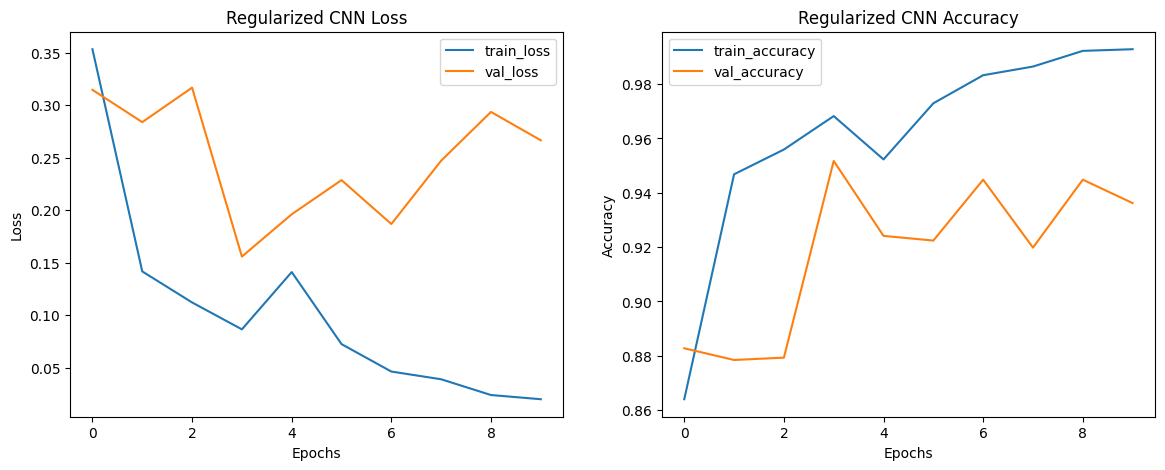

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history_scratch_cnn_model_reg2.history['loss'], label='train_loss')
axes[0].plot(history_scratch_cnn_model_reg2.history['val_loss'], label='val_loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Regularized CNN Loss')
axes[0].legend()

axes[1].plot(history_scratch_cnn_model_reg2.history['accuracy'], label='train_accuracy')
axes[1].plot(history_scratch_cnn_model_reg2.history['val_accuracy'], label='val_accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Regularized CNN Accuracy')
axes[1].legend()

plt.show()

### BatchNormalization & Dropout

In [ ]:
scratch_cnn_model_reg = models.Sequential([
        layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(224, 224, 3)),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.2),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(1, activation='sigmoid')
    ])

scratch_cnn_model_reg.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
scratch_cnn_model_reg.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 224, 224, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_5 (Conv2D)           (None, 222, 222, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 111, 111, 32)      0         
                                                                 
 conv2d_6 (Conv2D)           (None, 109, 109, 64)     

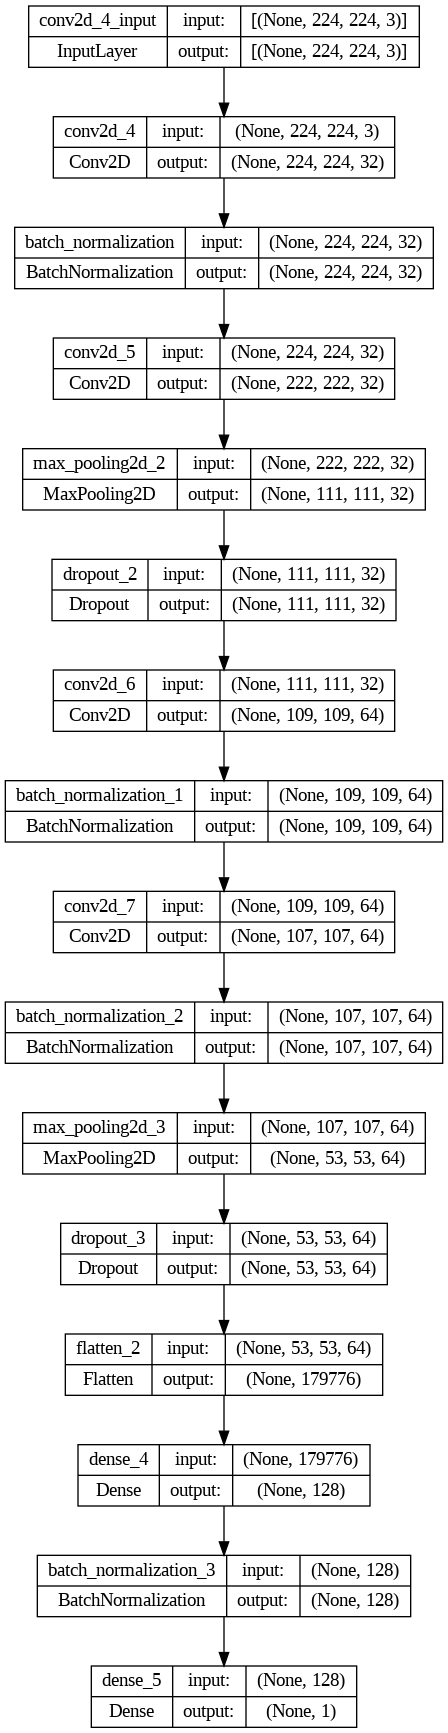

In [ ]:
keras.utils.plot_model(scratch_cnn_model_reg, "scratch_cnn_model_reg.png", show_shapes=True)

### dropout, batchnormalization acc: 0.9986, val_accuracy: 0.3934 but overfitting **worse one**!!

In [ ]:
scratch_cnn_model_reg_history = scratch_cnn_model_reg.fit(train, batch_size=256, epochs=10, validation_data=val)

Epoch 1/10
139/139 [==============================] - 104s 706ms/step - loss: 0.1683 - accuracy: 0.9421 - val_loss: 74.2707 - val_accuracy: 0.7433
Epoch 2/10
139/139 [==============================] - 70s 500ms/step - loss: 0.0882 - accuracy: 0.9691 - val_loss: 12.8222 - val_accuracy: 0.7484
Epoch 3/10
139/139 [==============================] - 70s 504ms/step - loss: 0.0635 - accuracy: 0.9795 - val_loss: 14.8140 - val_accuracy: 0.4598
Epoch 4/10
139/139 [==============================] - 72s 517ms/step - loss: 0.0415 - accuracy: 0.9874 - val_loss: 0.2030 - val_accuracy: 0.9246
Epoch 5/10
139/139 [==============================] - 70s 499ms/step - loss: 0.0383 - accuracy: 0.9874 - val_loss: 39.5026 - val_accuracy: 0.3116
Epoch 6/10
139/139 [==============================] - 71s 511ms/step - loss: 0.0257 - accuracy: 0.9914 - val_loss: 0.1502 - val_accuracy: 0.9604
Epoch 7/10
139/139 [==============================] - 70s 503ms/step - loss: 0.0147 - accuracy: 0.9950 - val_loss: 0.7186 - v

### Model Evaluation

#### Accuracy

In [ ]:
scratch_cnn_model_reg_acc = scratch_cnn_model_reg_history.history['accuracy'][-1:][0]
scratch_cnn_model_reg_val_acc = scratch_cnn_model_reg_history.history['val_accuracy'][-1:][0]

#### Loss

In [ ]:
scratch_cnn_model_reg_loss = scratch_cnn_model_reg_history.history['loss'][-1:][0]
scratch_cnn_model_reg_val_loss = scratch_cnn_model_reg_history.history['val_loss'][-1:][0]
print(f'ResNet50 Loss: {scratch_cnn_model_reg_loss}, ResNet50 Validation Loss: {scratch_cnn_model_reg_val_loss}')

ResNet50 Loss: 0.007330730557441711, ResNet50 Validation Loss: 83.83975219726562


#### F1 Score

In [ ]:
train_true_labels_scratch_cnn_model = train.classes
val_true_labels_scratch_cnn_model = val.classes

train_scratch_cnn_model_reg_predicted = scratch_cnn_model_reg.predict(train)
train_scratch_cnn_model_reg_binary_predicted = (train_scratch_cnn_model_reg_predicted > 0.5).astype(int)

val_scratch_cnn_model_reg_predicted = scratch_cnn_model_reg.predict(val)
val_scratch_cnn_model_reg_binary_predicted = (val_scratch_cnn_model_reg_predicted > 0.5).astype(int)

25/25 [==============================] - 9s 372ms/step


In [ ]:
train_scratch_cnn_model_reg_f1_score = f1_score(train_true_labels_scratch_cnn_model, train_scratch_cnn_model_reg_binary_predicted, average='macro')
val_scratch_cnn_model_reg_f1_score = f1_score(val_true_labels_scratch_cnn_model, val_scratch_cnn_model_reg_binary_predicted, average='macro')

print(f'CNN F1 Score: {train_scratch_cnn_model_reg_f1_score}')
print(f'CNN validation F1 Score: {val_scratch_cnn_model_reg_f1_score}')

CNN F1 Score: 0.31302292027372414
CNN validation F1 Score: 0.3145139535922867


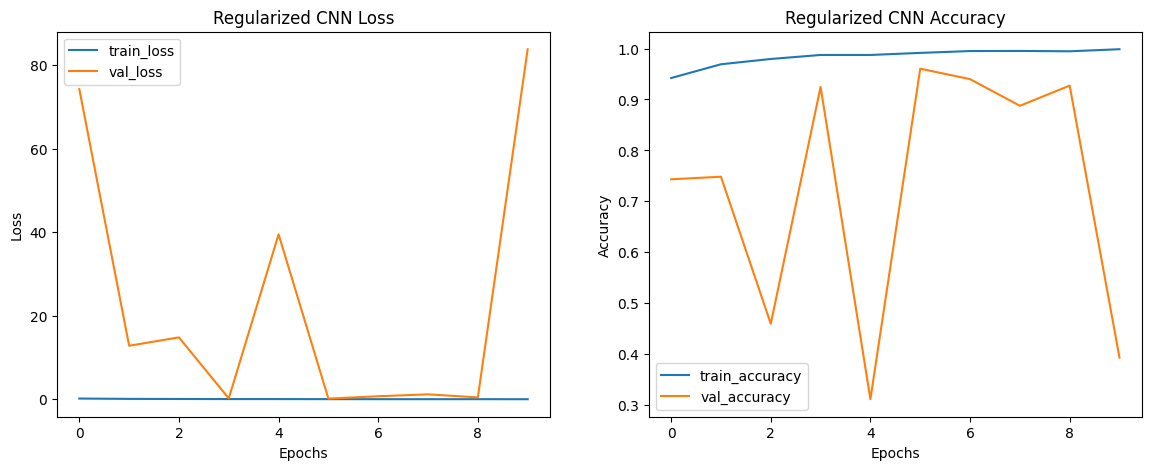

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(scratch_cnn_model_reg_history.history['loss'], label='train_loss')
axes[0].plot(scratch_cnn_model_reg_history.history['val_loss'], label='val_loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Regularized CNN Loss')
axes[0].legend()

axes[1].plot(scratch_cnn_model_reg_history.history['accuracy'], label='train_accuracy')
axes[1].plot(scratch_cnn_model_reg_history.history['val_accuracy'], label='val_accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Regularized CNN Accuracy')
axes[1].legend()

plt.show()

### Dropout Only

In [ ]:
scratch_cnn_model_d = models.Sequential([
        layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(224, 224, 3)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        # layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.2),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

scratch_cnn_model_d.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
scratch_cnn_model_d.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 conv2d_9 (Conv2D)           (None, 222, 222, 32)      9248      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 111, 111, 32)      0         
                                                                 
 conv2d_10 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 107, 107, 64)      36928     
                                                      

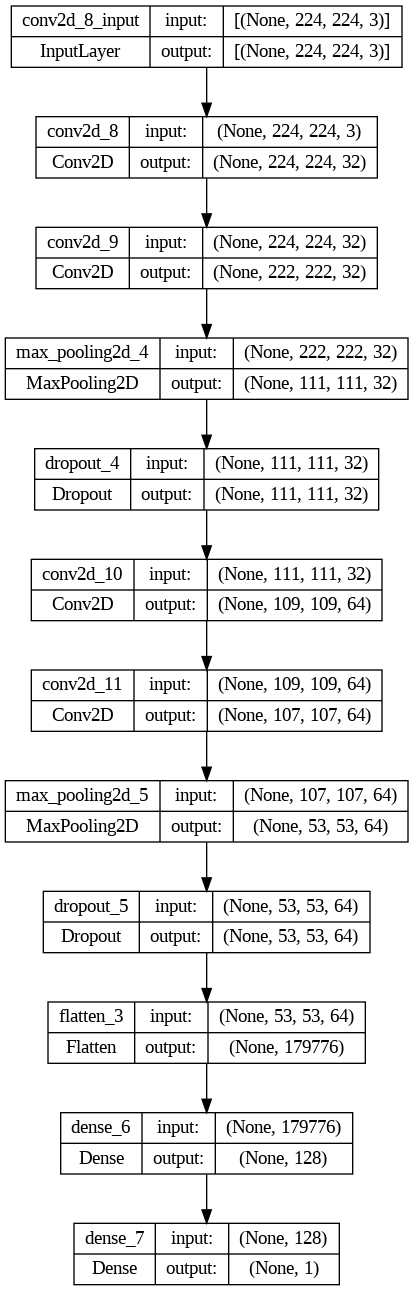

In [ ]:
keras.utils.plot_model(scratch_cnn_model_d, "scratch_cnn_model_d.png", show_shapes=True)

### dropout train/val generator acc: 0.8736, val_accuracy: 0.8046 but still overfitting

In [ ]:
start_time_cnn_gen = time.time()
scratch_cnn_model_d_history = scratch_cnn_model_d.fit(train_generator, batch_size=256, epochs=10, validation_data=val_generator)
cnn_gen_time = time.time() - start_time_cnn_gen
print(cnn_gen_time)

Epoch 1/10
139/139 [==============================] - 139s 990ms/step - loss: 36.2788 - accuracy: 0.7711 - val_loss: 0.3987 - val_accuracy: 0.7905
Epoch 2/10
139/139 [==============================] - 140s 1s/step - loss: 0.4417 - accuracy: 0.8159 - val_loss: 0.4331 - val_accuracy: 0.7829
Epoch 3/10
139/139 [==============================] - 142s 1s/step - loss: 0.3973 - accuracy: 0.8355 - val_loss: 0.4014 - val_accuracy: 0.7893
Epoch 4/10
139/139 [==============================] - 138s 994ms/step - loss: 0.3763 - accuracy: 0.8378 - val_loss: 0.4385 - val_accuracy: 0.7701
Epoch 5/10
139/139 [==============================] - 141s 1s/step - loss: 0.3606 - accuracy: 0.8429 - val_loss: 0.3852 - val_accuracy: 0.8110
Epoch 6/10
139/139 [==============================] - 138s 987ms/step - loss: 0.3348 - accuracy: 0.8497 - val_loss: 0.3983 - val_accuracy: 0.8008
Epoch 7/10
139/139 [==============================] - 138s 989ms/step - loss: 0.3194 - accuracy: 0.8610 - val_loss: 0.3793 - val_acc

### dropout acc: 0.9903, val_accuracy: 0.9489 **accurate** but still overfitting

In [ ]:
scratch_cnn_model_d_history = scratch_cnn_model_d.fit(train, batch_size=256, epochs=10, validation_data=val)

Epoch 1/10
139/139 [==============================] - 70s 490ms/step - loss: 0.3694 - accuracy: 0.8639 - val_loss: 0.1773 - val_accuracy: 0.9144
Epoch 2/10
139/139 [==============================] - 71s 513ms/step - loss: 0.1394 - accuracy: 0.9479 - val_loss: 0.1708 - val_accuracy: 0.9246
Epoch 3/10
139/139 [==============================] - 70s 506ms/step - loss: 0.2181 - accuracy: 0.9516 - val_loss: 0.1754 - val_accuracy: 0.9183
Epoch 4/10
139/139 [==============================] - 69s 496ms/step - loss: 0.0987 - accuracy: 0.9628 - val_loss: 0.1798 - val_accuracy: 0.9310
Epoch 5/10
139/139 [==============================] - 72s 519ms/step - loss: 0.0770 - accuracy: 0.9734 - val_loss: 0.1722 - val_accuracy: 0.9246
Epoch 6/10
139/139 [==============================] - 71s 513ms/step - loss: 0.0570 - accuracy: 0.9808 - val_loss: 0.1872 - val_accuracy: 0.9298
Epoch 7/10
139/139 [==============================] - 71s 512ms/step - loss: 0.0512 - accuracy: 0.9797 - val_loss: 0.1555 - val_ac

### Model Evaluation

#### Accuracy

In [ ]:
scratch_cnn_model_d_acc = scratch_cnn_model_d_history.history['accuracy'][-1:][0]
scratch_cnn_model_d_val_acc = scratch_cnn_model_d_history.history['val_accuracy'][-1:][0]

#### Loss

In [ ]:
scratch_cnn_model_d_loss = scratch_cnn_model_d_history.history['loss'][-1:][0]
scratch_cnn_model_d_val_loss = scratch_cnn_model_d_history.history['val_loss'][-1:][0]
print(f'ResNet50 Loss: {scratch_cnn_model_d_loss}, ResNet50 Validation Loss: {scratch_cnn_model_d_val_loss}')

ResNet50 Loss: 0.029940862208604813, ResNet50 Validation Loss: 0.15930217504501343


#### F1 Score

In [ ]:
train_scratch_cnn_model_d_predicted = scratch_cnn_model_d.predict(train)
train_scratch_cnn_model_d_binary_predicted = (train_scratch_cnn_model_d_predicted > 0.5).astype(int)

val_scratch_cnn_model_d_predicted = scratch_cnn_model_d.predict(val)
val_scratch_cnn_model_d_binary_predicted = (val_scratch_cnn_model_d_predicted > 0.5).astype(int)

25/25 [==============================] - 10s 402ms/step


In [ ]:
train_scratch_cnn_model_d_f1_score = f1_score(train.classes, train_scratch_cnn_model_d_binary_predicted, average='macro')
val_scratch_cnn_model_d_f1_score = f1_score(val.classes, val_scratch_cnn_model_d_binary_predicted, average='macro')

print(f'Dropout with CNN F1 Score: {train_scratch_cnn_model_d_f1_score}')
print(f'Dropout with CNN validation F1 Score: {val_scratch_cnn_model_d_f1_score}')

Dropout with CNN F1 Score: 0.5069200266330104
Dropout with CNN validation F1 Score: 0.5116508722995097


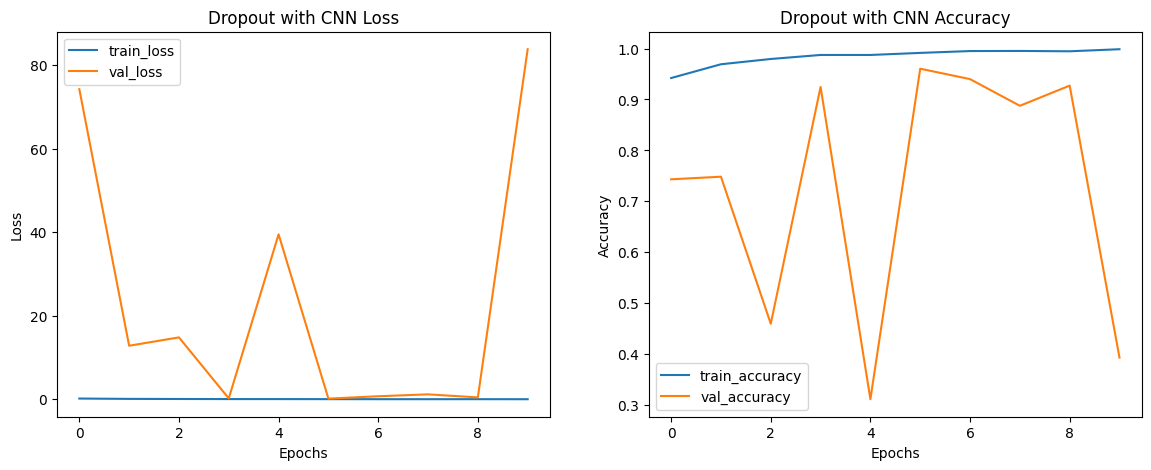

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(scratch_cnn_model_reg_history.history['loss'], label='train_loss')
axes[0].plot(scratch_cnn_model_reg_history.history['val_loss'], label='val_loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Dropout with CNN Loss')
axes[0].legend()

axes[1].plot(scratch_cnn_model_reg_history.history['accuracy'], label='train_accuracy')
axes[1].plot(scratch_cnn_model_reg_history.history['val_accuracy'], label='val_accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Dropout with CNN Accuracy')
axes[1].legend()

plt.show()

## Test the Best Model

In [ ]:
test_loss, test_accuracy = ResNet50_model2.evaluate(test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

10/10 [==============================] - 472s 52s/step - loss: 0.4727 - accuracy: 0.7734
Test Loss: 0.47273707389831543
Test Accuracy: 0.7734375


In [ ]:
y_pred = ResNet50_model2.predict(test)
y_pred = (y_pred > 0.5).astype(int)

print(classification_report(test.classes, y_pred))

10/10 [==============================] - 9s 908ms/step
              precision    recall  f1-score   support

           0       0.38      0.24      0.30       242
           1       0.62      0.77      0.69       398

    accuracy                           0.57       640
   macro avg       0.50      0.50      0.49       640
weighted avg       0.53      0.57      0.54       640



# References
* [Image Processing](https://www.youtube.com/watch?v=uqomO_BZ44g)
* [VGG16](https://www.youtube.com/watch?v=zBOavqh3kWU)
* [Pretrained Models Documentation](https://keras.io/api/applications/#usage-examples-for-image-classification-models)
* [Images Augmentation](https://www.youtube.com/watch?v=ccdssX4rIh8)
* [Model Fine-tuning](https://keras.io/api/applications/#usage-examples-for-image-classification-models)
* [Fine-tuning](https://www.youtube.com/watch?v=h_rz7_sIV40)